# Problem Solving : Stellar Mass

Using the techniques we have learned to date we can already solve many problems.  Here we use some simple data of a spherically symmetric star, calculate some of its properties, and analyze an apparent error in the provided data.  As with any problem we must first spend some time understanding the set up, analytically manipulating it, and finally turning the analysis into simple problems we can solve numerically.  Most of the analytic work will be done in class.  In general the results from that discussion will be presented and used in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as opt
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Problem Statement

We will solve part of computational problem C 8.1 from Fowles and Cassiday, *Analytical Mechanics*, 7th edition.  In this problem we are given the density of a 10 solar mass star as a function of radial distance from its core.  Actually, the densities are given as $\log_{10}(\rho/\rho_c)$ where $\rho$ is the density a distance $r$ and $\rho_c$ is the density at the core of the star.  The distances are given as fractions of the star's radius, $r/R_*$.  Finally we are told that the radius of the star is 4 solar radii.

There are a few questions asked based on the data given in the table.  The two we will address are
1. Using the data in the table, estimate the core density of the star by numerical integration.
2. Find the distance, $R_3$, such that the mass contained within $R_3$ is equal to 3 solar masses. 

### Data

As discussed in class, we designate the data provided by the variables
$$ \eta\equiv \frac{r}{R_*}, \quad g(\eta)\equiv\log_{10} \left(\frac{\rho}{\rho_c}\right). $$
The data is provided in arrays here.

In [2]:
eta = np.array([ 0., 0.0113, 0.02373, 0.0374, 0.05244, 0.06898, 0.08718, 0.1072,
    0.12921, 0.15343, 0.18008, 0.20938, 0.24162, 0.27708, 0.31609, 0.359,
    0.4062,  0.45812, 0.51523, 0.57805, 0.64715, 0.72316, 0.80678, 0.89876, 1.])
g = np.array([ 0.00000000e+00, -7.67600000e-04, -3.29790000e-03, -8.11050000e-03,
    -1.59332000e-02, -2.75835000e-02, -4.40001000e-02, -6.66168000e-02,
    -9.66376000e-02, -1.36117000e-01, -1.87302000e-01, -2.53082000e-01,
    -3.38876000e-01, -4.61671000e-01, -6.07536000e-01, -7.80852000e-01,
    -9.49463000e-01, -1.20746000e+00, -1.46811000e+00, -1.77071000e+00,
    -2.12543000e+00, -2.55734000e+00, -3.11969000e+00, -3.95562000e+00,
    -6.28531000e+00])

For future use we also initialize some parameters here.  We will write the solar mass and radius in SI units.  This is useful for comparing our results to known quantities.

In [3]:
Mstar = 10. # Msun
Rstar = 4. # Rsun
Msun = 1.988e30 # kg
Rsun = 6.96e8 # m

### Analytic Manipulations

In class we discussed how to use the given data to perform the required calculations.  This involved analytic manipulations of some basic relations to reduce them to forms which separate the physics from the mathematics, leaving a "simple number" that needs to be calculated numerically.  In particular, we showed that starting from the general relation between the mass and density,
$$ M_* = \int \rho(\vec r)\,\mathrm{d}V, $$
that since we have a spherically symmetric star and defining dimensionless variables we could write the mass as
$$ M_* = 4\pi R_*^3 \rho_c I_1, $$
where all the dimensionfull information is contained in the prefactor and $I_1$ is a dimensionless number we calculate as
$$ I_1 \equiv \int_{0}^{1} \eta^2 10^{g(\eta)}\, \mathrm{d}\eta, $$
here written in terms of the variables defined above (and provided as the data in our problem).

It is convenient to calculate the integrand in this expression as we will use it repeatedly below.

In [4]:
integrand = eta**2 * 10**g

### Core Density

Given the mass of the star and its radius we can now calculate the core density as
$$ \rho_c = \frac{M_*}{4\pi R_*^3 I_1} = \frac{10}{4^4\pi I_1} \frac{M_\odot}{R_\odot^3}, $$
where we have used the values for $M_*$ and $R_*$ and calculate the result in simple but odd seeming units.

We now need to evaluate the integral, $I_1$.  This can be done in a few ways.  Here we calculate the integral in two different ways, using the trapezoidal rule and through a spline.  Both are in good agreement with each other.  We arbitrarily choose to use the spline to calculate the core density.

In [5]:
It1 = integ.trapz(integrand, eta)
spline1 = interp.InterpolatedUnivariateSpline(eta, integrand)
Is1 = spline1.integral(0, 1)
rhoc = Mstar/(4.*np.pi*Rstar**3*Is1) # Msun/Rsun^3

print(f"Integrals : Trapezoid = {It1}, Spline = {Is1}")
print(f"Core density (from spline) : {rhoc} (Msun/Rsun^3)")

Integrals : Trapezoid = 0.009379641509996295, Spline = 0.009365803824090217
Core density (from spline) : 1.3275934626211483 (Msun/Rsun^3)


The core density we found is nice, but what does it mean?  We should compare it to something we know to see if it is reasonable.  The central density of the Sun is $1.62\times 10^5\,\mathrm{kg/m^3}$ so we should convert the units of our answer and compare.  We find the value for our star is about a factor of 20 smaller than that for the Sun.  This is close to the right order of magnitude but is it close enough? It is hard to say without knowing more about the star and stellar interiors. At least it is not a completely crazy value!

In [6]:
print(f"Core density : {rhoc*Msun/Rsun**3} kg/m^3")

Core density : 7828.053162375384 kg/m^3


### Radius Containing 3 Solar Masses

Next we wish to find the radius within which 3 solar masses are contained.  For this we generalize our mass calculation from above.  Out to a radius $R$ we can calculate the mass enclosed as
$$ M(R) = \frac{M_*}{I_1} I\left( \frac{R}{R_*} \right), $$
where
$$ I\left(\frac{R}{R_*} \right) \equiv \int_0^{R/R_*} \eta^2 10^{g(\eta)}\, \mathrm{d}\eta. $$

We wish to find $R_3$ such that $M(R_3)=3 M_\odot$.  Using the above this means we wish to solve the equation
$$ I\left(\frac{R_3}{R_*}\right) - \frac{3 M_\odot}{M_*} I_1 = 0 $$
for $R_3$.  Naturally we need to use a root finder for this purpose.  Our usual approach would be to define a function for the left hand side of the equation, then use a root finder like `brentq`.  This is a perfectly good way to do things, but, as we saw when discussing solving ODE's, we can instead use a lambda function.  Here is another case where they are useful.

For our purpose we need to evaluate the integral.  We do this using our spline constructed above.  In fact, we can construct a new spline from the original which will be the integral we require.  The code for doing these steps is given below.

In [7]:
i = spline1.antiderivative() # Spline that is the integral.
R3 = opt.brentq(lambda r : i(r) - 3./Mstar*i(1), 0, 1)
print(f"R3 = {R3} Rstar")

R3 = 0.23396456356511772 Rstar


### Revisit the Data

There are a few more questions asked in the original problem.  We could solve these in similar ways but will instead go back to the original data.  One thing we should have done at the very beginning was actually look at the data.  Here is a quick plot of the integrand.  This is the function we are integrating so it is good to know what it looks like to see if there is anything that may cause difficulties.

In fact, when I first typed in the table of values I did look at the data.  This is a good way to see if any typos were made.  We expect the integrand to be a simple, smooth function.  I found one typo (since corrected) by doing this.  Do we see anything peculiar in the data?

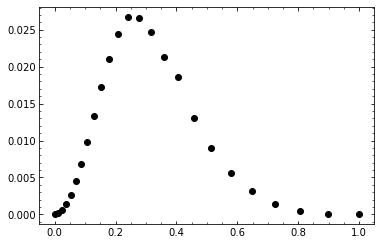

In [8]:
plt.plot(eta, integrand, 'ko')

It is not too easy to see odd behavior since we just see a bunch of points.  To make this more clear let us also draw a smooth line from the spline constructed above. Now we should see one point that stands out as peculiar.

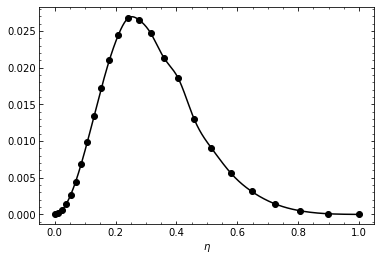

In [9]:
eta_fine = np.linspace(0, 1, 1000)
plt.plot(eta, integrand, 'ko')
plt.plot(eta_fine, spline1(eta_fine), 'k-')
plt.xlabel(r'$\eta$');

The point around 0.4 looks strange.  There is a small bump which seems out of place.  Physically, such a bump would mean there is some special radius in the star (another length scale).  Should there be such a scale?  In a star there are other scales, for example due to diffusion or convection, however it is not clear that such effects are included in the data provided.  I would expect it is not.  If it is not then this looks like an error.  Let us analyze it in more detail.

If this is a bad point then let us remove it and estimate what the "correct" value would be.  This can be done by using interpolation.  We construct a new spline with this data point excluded, then evaluate the spline at the value of $\eta$ that was the bad point.  To slice out the bad data point we could use the `where` function to select the index value of the bad point and the index values of the good points or construct a boolean array and negate it.  I choose the latter approach here.  It is a little simpler but does not produce as nice output.

In [10]:
ind_good = (eta<0.39) | (eta>0.41)
ind_bad = ~ind_good # Negate the boolean array of good index values.
spline2 = interp.InterpolatedUnivariateSpline(eta[ind_good], 
                                              eta[ind_good]**2 * 10**g[ind_good])
integrand_new = spline2(eta[ind_bad])
g_new = np.log10(integrand_new/eta[ind_bad]**2)
print(f"For eta = {eta[ind_bad]}, Old value = {g[ind_bad]}, New value = {g_new}")

For eta = [0.4062], Old value = [-0.949463], New value = [-0.97980335]


Notice the values, they change from -0.949 to -0.979.  If we look at a numeric key pad we notice the 4 appears directly below the 7.  This would be a very easy typo to make.  This does not prove that there is a typo in the data, but it is very suggestive!

We can now repeat the above analysis with the new spline.  Here are the results.

In [11]:
print (f"""For the corrected data we find:
\tCentral density (from spline) = {Mstar/(4.*np.pi*Rstar**3*spline2.integral(0,1))} (Msun/Rsun^3)""")

i = spline2.antiderivative()
R3_new = opt.brentq(lambda r : i(r) - 3./Mstar*i(1), 0, 1)
print(f"\tR3 = {R3_new} Rstar")

For the corrected data we find:
	Central density (from spline) = 1.3364195832377537 (Msun/Rsun^3)
	R3 = 0.23326262134156767 Rstar


Finally let us put it all together in a single plot.  Here we plot the original and corrected data points along with smooth curves (splines) through them.  We include the radius within which contains 3 solar masses of the star.  For fun we shade this region.

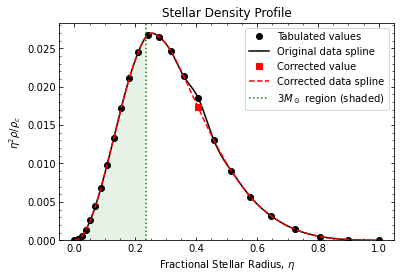

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(eta, integrand, 'ko', label='Tabulated values')
ax.plot(eta_fine, spline1(eta_fine), 'k-', label='Original data spline')
ax.plot(eta[ind_bad], integrand_new, 'rs', label='Corrected value')
ax.plot(eta_fine, spline2(eta_fine), 'r--', label='Corrected data spline')
ax.axvline(R3, color='g', ls=':', label=r'$3 M_\odot$ region (shaded)')
# For fun lets fill the 3 Msun region.  We set a small alpha so that it is
# mostly transparent.  Notice that we can tell it where to fill using
# syntax like we discussed for conditional array slicing (recall that
# eta_fine<=R3 will produce a boolean array).
ax.fill_between(eta_fine, spline1(eta_fine), facecolor='g',
                alpha=0.1, where=eta_fine<=R3)
ax.set_xlabel(r'Fractional Stellar Radius, $\eta$')
ax.set_ylabel(r'$\eta^2 \rho/\rho_c$')
ax.set_title('Stellar Density Profile')
ax.set_ylim(bottom=0)
# I prefer only 1 point show up in the legend, not 2.
ax.legend(numpoints=1);